# Gesture Recognition Project
This project involves building a 3D Convolutional Neural Network (CNN) to correctly recognize hand gestures by a user to control a smart TV.

The objective of this projects is to build a hand gesture recognition model that can be hosted on a camera installed in a smart TV that can understand 5 gestures. 

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
-	Thumbs up:  Increase the volume
-	Thumbs down: Decrease the volume
-	Left swipe: 'Jump' backwards 10 seconds
-	Right swipe: 'Jump' forward 10 seconds  
-	Stop: Pause the movie


### Contributors : Ankan Putatunda,

#### Python version : 3, Tensorflow version : '1.10.0'

## Understanding the DataSet:

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

In [5]:
# Doing the required imports :
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.losses import categorical_crossentropy
from keras.layers.convolutional import Conv2D, MaxPooling3D, Conv3D, MaxPooling2D
from keras.layers.recurrent import GRU
from keras.layers import Activation, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM

In [6]:
# Importing the python basic libraries and functions:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os

# Importing additional libraries which might be needed for image pre-processing :

#import resize as imresize
#import sckikit-image as skimage
import cv2
import imageio as imio
from PIL import Image

In [3]:
# Random seed is done to handle the reproducibility of the network and so that the results don't vary drastically:

In [7]:
np.random.seed(30)
import random as rn
rn.seed(30)

import tensorflow as tf
from keras import backend as K

import matplotlib.pyplot as plt

tf.random.set_seed(30)
#tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [8]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

#experiment with the batch size
batch_size = 25

In [9]:
# Custom function to crop image :

def crop_img(img, scale=1.0):
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return img_cropped

WIN_20180925_17_55_45_Pro_00030.png


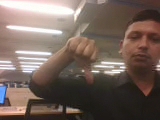

In [10]:
import os, random
from PIL import Image

folder=r"/home/datasets/Project_data/train/WIN_20180925_17_55_45_Pro_Thumbs_Down_new"

a=random.choice(os.listdir(folder))
print(a)

#os.open(a, os.O_RDWR)
file = folder+'/'+a
Image.open(file).show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. 

In [24]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,64,64,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.10)
    
# Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,64,64,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.10)

# Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [25]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 5
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# First Base Model : Conv 3D Model with 5 epochs, 25 batch size 
### Without dropouts in Conv layer and with batch normalization

### Input image size 64X64 , adam optimiser with learning rate 0.0002 with decay, 18 images as input out of 30 

In [26]:
# Building the first model which is 3D Conv model:

modelConv3D_1 = Sequential()

modelConv3D_1.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,64,64,3)))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))



modelConv3D_1.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))



modelConv3D_1.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))



modelConv3D_1.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))



modelConv3D_1.add(Flatten())
modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser = keras.optimizers.Adam(learning_rate=0.0002, decay=1e-6)
#optimiser = 
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# compile model :
modelConv3D_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 64, 64, 8)     656       
                                                                 
 activation_8 (Activation)   (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization_12 (Bat  (None, 18, 64, 64, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 32, 32, 8)     0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 32, 32, 16)     3472      
                                                                 
 activation_9 (Activation)   (None, 9, 32, 32, 16)    

In [27]:
print("Total Params in model:", modelConv3D_1.count_params())

Total Params in model: 144421


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [28]:
#write your optimizer
#optimiser = 
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
#model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [29]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [30]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = num_epochs)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, verbose=1)

callbacks_list = [ LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [32]:
# Modified the fit generator to use multiproessing to improve the training time :

# This is for first model 3D Conv model: (modelConv3D_1)

history = modelConv3D_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 25
Epoch 1/5
27/27 [==============================] - 25s 938ms/step - loss: 2.1944 - categorical_accuracy: 0.2202 - val_loss: 1.6276 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/5
27/27 [==============================] - ETA: 0s - loss: 1.8687 - categorical_accuracy: 0.3183
Epoch 00002: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
27/27 [==============================] - 22s 858ms/step - loss: 1.8687 - categorical_accuracy: 0.3183 - val_loss: 1.6875 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/5
27/27 [==============================] - ETA: 0s - loss: 1.7567 - categorical_accuracy: 0.3363
Epoch 00003: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.
27/27 [==============================] - 22s 849ms/step - loss: 1.7567 - categorical_accuracy: 0.3363 - val_loss: 1.7187 - val_categorical_accuracy: 0.1900 - lr: 4.0000e-05
Epoch 4/5
27/27 [================

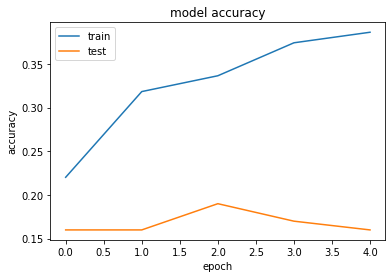

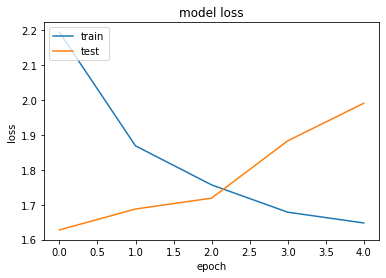

In [33]:
# Plotting the result of Model 1 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

So we have got the training accuarcy of 42 % and validation accuracy of 41 % in the base model

# Second Model  : Conv 3D Model with 20 epochs, 30 batch size 
Without dropouts in Conv layer and with batch normalization.
Input image size 64X64 , adam optimiser with learning rate 0.0002 without decay, 18 images as input out of 30
Changed droput to 0.50 from 0.25 in 1st dense layer 

In [34]:
batch_size = 30
num_epochs = 20

In [35]:
# Building the second model which is 3D Conv model:

modelConv3D_2 = Sequential()

modelConv3D_2.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,64,64,3)))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_2.add(Dropout(0.25))

modelConv3D_2.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_2.add(Dropout(0.25))

modelConv3D_2.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_2.add(Dropout(0.25))

modelConv3D_2.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_2.add(Dropout(0.25))

modelConv3D_2.add(Flatten())
modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.50))

modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.25))

modelConv3D_2.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser = keras.optimizers.Adam(lr=0.0002)
#optimiser = 
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# compile model :
modelConv3D_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 18, 64, 64, 8)     656       
                                                                 
 activation_12 (Activation)  (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization_18 (Bat  (None, 18, 64, 64, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 9, 32, 32, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 9, 32, 32, 16)     3472      
                                                                 
 activation_13 (Activation)  (None, 9, 32, 32, 16)    

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
print("Total Params in model:", modelConv3D_2.count_params())

Total Params in model: 144421


In [37]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [ LR]
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [38]:
# Modified the fit generator to use multiple worker without the multiprocessing training time :

# This is for second model 3D Conv model: )

history = modelConv3D_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,use_multiprocessing=True,
                    workers=4, initial_epoch=0)

/tmp/ipykernel_3547/1183778227.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelConv3D_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - 27s 1s/step - loss: 2.3007 - categorical_accuracy: 0.2449 - val_loss: 1.6455 - val_categorical_accuracy: 0.1333 - lr: 2.0000e-04
Epoch 2/20
23/23 [==============================] - 38s 2s/step - loss: 1.9924 - categorical_accuracy: 0.2942 - val_loss: 1.7356 - val_categorical_accuracy: 0.1333 - lr: 2.0000e-04
Epoch 3/20
23/23 [==============================] - 35s 2s/step - loss: 1.9896 - categorical_accuracy: 0.3058 - val_loss: 1.8647 - val_categorical_accuracy: 0.1333 - lr: 2.0000e-04
Epoch 4/20
23/23 [==============================] - 39s 2s/step - loss: 1.9071 - categorical_accuracy: 0.3007 - val_loss: 1.9913 - val_categorical_accuracy: 0.1333 - lr: 2.0000e-04
Epoch 5/20
23/23 [==============================] - ETA: 0s - loss: 1.7675 - categorical_accuracy: 0.3333
Epoch 00005: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
23/23 [===============

In [39]:
print("Total Params in model:", modelConv3D_2.count_params())

Total Params in model: 144421


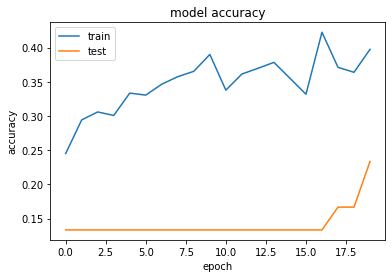

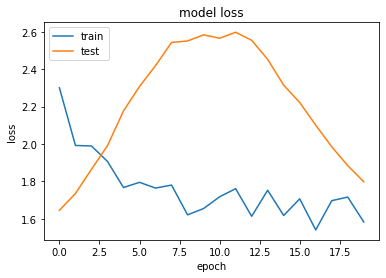

In [40]:
# Plotting the result of Model 2 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# So we have got best validation accuracy of 44 % from this model.

# Third Model  : Conv 3D Model with 20 epochs and 30 batch size , image size increaed to 84X84, reduced cropping to 3 % from 10 %
Without dropouts in Conv layer and with batch normalization.
adam optimiser with learning rate 0.0002 without decay, 18 images as input out of 30
Reverted back dropout from 0.50 to 0.25 in 1st dense layer 

In [41]:
# Modified generator function :

def generator_modified(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,84,84,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 3 % of original size :
                    image = crop_img(image, 0.03)
    
# Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Cropping image by 3 % of original size :
                    image = crop_img(image, 0.03)

# Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [48]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

batch_size = 30
print ('# batch_size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 30


In [49]:
# Building the  model which is 3D Conv model:

modelConv3D_3 = Sequential()

modelConv3D_3.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,84,84,3)))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Flatten())

modelConv3D_3.add(Dense(128, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Dense(64, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser =  keras.optimizers.Adam(lr=0.0002)
#optimiser = 
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# compile model :
modelConv3D_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_3.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 18, 84, 84, 8)     656       
                                                                 
 activation_24 (Activation)  (None, 18, 84, 84, 8)     0         
                                                                 
 batch_normalization_36 (Bat  (None, 18, 84, 84, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 9, 42, 42, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 9, 42, 42, 16)     3472      
                                                                 
 activation_25 (Activation)  (None, 9, 42, 42, 16)    

In [50]:
print("Total Params in model:", modelConv3D_3.count_params())

Total Params in model: 288101


In [51]:
train_generator = generator_modified(train_path, train_doc, batch_size)
val_generator = generator_modified(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [52]:
history = modelConv3D_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,
                    workers=1, initial_epoch=0)

/tmp/ipykernel_3547/1137570482.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelConv3D_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.0822 - categorical_accuracy: 0.2459Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2024-11-0621_07_24.683557/model-00001-2.08219-0.24585-1.62168-0.17000.h5
23/23 [==============================] - 29s 1s/step - loss: 2.0822 - categorical_accuracy: 0.2459 - val_loss: 1.6217 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.8909 - categorical_accuracy: 0.3047
Epoch 00002: saving model to model_init_2024-11-0621_07_24.683557/model-00002-1.89091-0.30468-1.63788-0.15000.h5
23/23 [==============================] - 26s 1s/step - loss: 1.8909 - categorical_accuracy: 0.3047 - val_loss: 1.6379 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/20
22/23 [===========================>..] - ETA: 0s - loss: 1.6925 - categorical_a

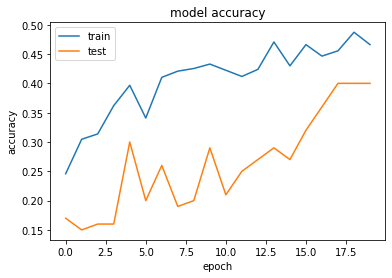

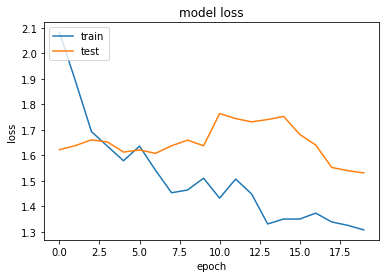

In [53]:
# Plotting the result of Model 3 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Best validation accuracy is 40 % only.

# Fourth Model : Conv 3D model 
## Increase the image size to 100x100, batch size 50, epoch 30

In [54]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [55]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,100,100,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.02)
    
# Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,100,100,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.02)

# Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [56]:
modelConv3D_4 = Sequential()

modelConv3D_4.add(Conv3D(8, 
                 kernel_size=(3,3,3), 
                 input_shape=(18,100,100,3),
                 padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_4.add(Conv3D(16, 
                 kernel_size=(3,3,3), 
                 padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_4.add(Conv3D(32, 
                 kernel_size=(1,3,3), 
                 padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_4.add(Conv3D(64, 
                 kernel_size=(1,3,3), 
                 padding='same'))
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(Dropout(0.25))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
modelConv3D_4.add(Flatten())

modelConv3D_4.add(Dense(256, activation='relu'))
modelConv3D_4.add(Dropout(0.25))

modelConv3D_4.add(Dense(128, activation='relu'))
modelConv3D_4.add(Dropout(0.25))

#softmax layer
modelConv3D_4.add(Dense(5, activation='softmax'))

In [58]:
optimiser = keras.optimizers.Adam() #write your optimizer
modelConv3D_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelConv3D_4.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 18, 100, 100, 8)   656       
                                                                 
 batch_normalization_42 (Bat  (None, 18, 100, 100, 8)  32        
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 18, 100, 100, 8)   0         
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 9, 50, 50, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 9, 50, 50, 16)     3472      
                                                                 
 batch_normalization_43 (Bat  (None, 9, 50, 50, 16)   

In [59]:
print("Total Params in model:", modelConv3D_4.count_params())

Total Params in model: 651109


In [63]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

batch_size = 50
num_epochs = 30

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# training sequences = 663
# validation sequences = 100


In [64]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [65]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = modelConv3D_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


/tmp/ipykernel_3547/1584921835.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelConv3D_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 50
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 1.9234 - categorical_accuracy: 0.2217Source path =  /home/datasets/Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2024-11-0621_18_36.037704/model-00001-1.92345-0.22172-1.60773-0.19000.h5
14/14 [==============================] - 29s 2s/step - loss: 1.9234 - categorical_accuracy: 0.2217 - val_loss: 1.6077 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 1.5750 - categorical_accuracy: 0.2866
Epoch 00002: saving model to model_init_2024-11-0621_18_36.037704/model-00002-1.57503-0.28658-1.60642-0.18000.h5
14/14 [==============================] - 27s 2s/step - loss: 1.5750 - categorical_accuracy: 0.2866 - val_loss: 1.6064 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 1.5509 - categorical_accuracy:

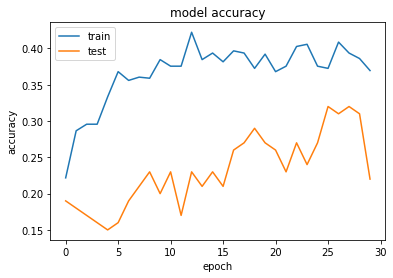

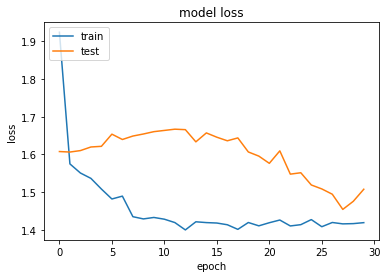

In [66]:
# Plotting the result of Model 4 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Best validation accuracy of 32 %.

# Model 5 : Conv 3D model

## batch size 30, increased image inputs to 30 , image size recuced to 84

In [1]:
batch_size = 30

In [2]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)] 
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,84,84,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [13]:

#write your model here

modelConv3D_5 = Sequential()

modelConv3D_5.add(Conv3D(8, (3,3,3), padding='same', input_shape=(30,84,84,3)))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Flatten())
modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser = tf.keras.optimizers.Adam(lr=0.0002)
#optimiser = 
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# compile model :
modelConv3D_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelConv3D_5.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 84, 84, 8)     656       
                                                                 
 activation_4 (Activation)   (None, 30, 84, 84, 8)     0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 84, 84, 8)    32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 42, 42, 8)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 42, 42, 16)    3472      
                                                                 
 activation_5 (Activation)   (None, 15, 42, 42, 16)   

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
print("Total Params in model:", modelConv3D_5.count_params())

Total Params in model: 181285


In [15]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
history = modelConv3D_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_207/1110807313.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelConv3D_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 25
Epoch 1/30


2024-11-07 10:39:10.012469: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


27/27 [==============================] - ETA: 0s - loss: 2.0674 - categorical_accuracy: 0.2655Source path =  /home/datasets/Project_data/val ; batch size = 25

Epoch 00001: saving model to model_init_2024-11-0710_38_38.705939/model-00001-2.06736-0.26546-1.61017-0.27000.h5
27/27 [==============================] - 89s 3s/step - loss: 2.0674 - categorical_accuracy: 0.2655 - val_loss: 1.6102 - val_categorical_accuracy: 0.2700 - lr: 2.0000e-04
Epoch 2/30
27/27 [==============================] - ETA: 0s - loss: 1.4537 - categorical_accuracy: 0.4540
Epoch 00002: saving model to model_init_2024-11-0710_38_38.705939/model-00002-1.45368-0.45400-1.72768-0.19000.h5
27/27 [==============================] - 49s 2s/step - loss: 1.4537 - categorical_accuracy: 0.4540 - val_loss: 1.7277 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/30
27/27 [==============================] - ETA: 0s - loss: 1.2997 - categorical_accuracy: 0.4977
Epoch 00003: saving model to model_init_2024-11-0710_38_38.705

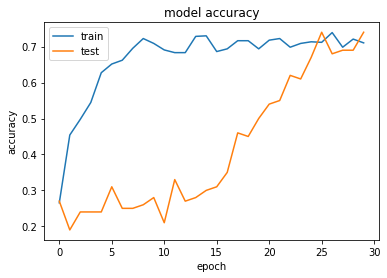

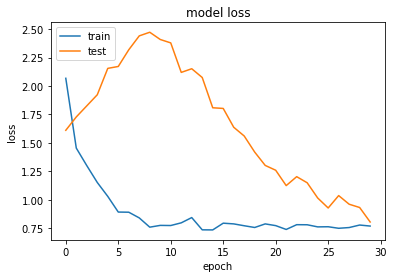

In [17]:
# Plotting the result of Model 5 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# We have achieved the best test accuracy of 74 % and validation accuracy of 74 % by the convolutional model.

### _We have tried multiple experiments with Conv 3D model but the performance of models are not as expected, so lets try with the other models for the same problem statement._

# Model 6 : CNN - LSTM Model 

In [18]:
# Input
input_shape=(30,120,120,3)

In [20]:

#write your model here
CNNlstm_1 = Sequential()

CNNlstm_1.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Flatten()))


CNNlstm_1.add(LSTM(128))
CNNlstm_1.add(Dropout(0.25))

CNNlstm_1.add(Dense(128,activation='relu'))
CNNlstm_1.add(Dropout(0.25))

CNNlstm_1.add(Dense(5, activation='softmax'))


#write your optimizer
optimiser = tf.keras.optimizers.Adam()
#optimiser = 
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# compile model :
CNNlstm_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_1.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 60, 60, 32)  

In [25]:
batch_size = 20
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [26]:
def generatorLSTM(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,120,120,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [27]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [28]:
history = CNNlstm_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_207/2841256302.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = CNNlstm_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4815 - categorical_accuracy: 0.3454Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-11-0711_40_36.342683/model-00001-1.48151-0.34540-1.70819-0.30000.h5
34/34 [==============================] - 59s 2s/step - loss: 1.4815 - categorical_accuracy: 0.3454 - val_loss: 1.7082 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1837 - categorical_accuracy: 0.5324
Epoch 00002: saving model to model_init_2024-11-0711_40_36.342683/model-00002-1.18372-0.53243-1.97385-0.20000.h5
34/34 [==============================] - 52s 2s/step - loss: 1.1837 - categorical_accuracy: 0.5324 - val_loss: 1.9738 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0207 - categorical_accuracy:

In [29]:
print("Total Params in model:", CNNlstm_1.count_params())

Total Params in model: 1657445


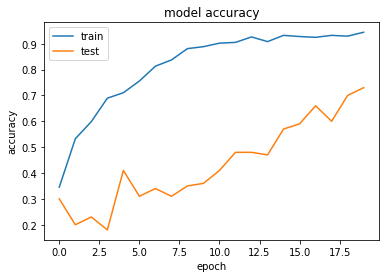

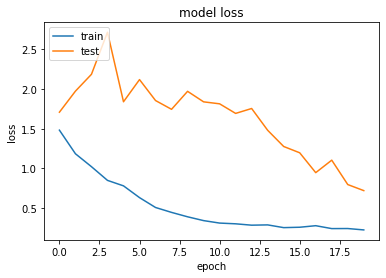

In [30]:
# Plotting the result of Model 6 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Best test accuracy of 94% and validation accuracy of 73 % with this model.

# Model 7 : CNN - LSTM Model , increase input image size to 160x160 

In [32]:
# Input
input_shape=(30,160,160,3)


#write your model here
CNNlstm_2 = Sequential()

CNNlstm_2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Flatten()))


CNNlstm_2.add(LSTM(128))
CNNlstm_2.add(Dropout(0.25))

CNNlstm_2.add(Dense(128,activation='relu'))
CNNlstm_2.add(Dropout(0.25))

CNNlstm_2.add(Dense(5, activation='softmax'))


#write your optimizer
optimiser = tf.keras.optimizers.Adam()
#optimiser = 
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# compile model :
CNNlstm_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_2.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 30, 160, 160, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 30, 160, 160, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 30, 80, 80, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 30, 80, 80, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 30, 80, 80, 32)  

In [33]:
print("Total Params in model:", CNNlstm_2.count_params())

Total Params in model: 3754597


In [34]:
def generatorLSTM1(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,160,160,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,160,160,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [35]:
train_generator = generatorLSTM1(train_path, train_doc, batch_size)
val_generator = generatorLSTM1(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [36]:
history = CNNlstm_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_207/1818313263.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = CNNlstm_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4778 - categorical_accuracy: 0.3831Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-11-0711_40_36.342683/model-00001-1.47782-0.38311-1.67363-0.12000.h5
34/34 [==============================] - 69s 2s/step - loss: 1.4778 - categorical_accuracy: 0.3831 - val_loss: 1.6736 - val_categorical_accuracy: 0.1200 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2694 - categorical_accuracy: 0.4827
Epoch 00002: saving model to model_init_2024-11-0711_40_36.342683/model-00002-1.26938-0.48265-1.61794-0.20000.h5
34/34 [==============================] - 66s 2s/step - loss: 1.2694 - categorical_accuracy: 0.4827 - val_loss: 1.6179 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1472 - categorical_accuracy:

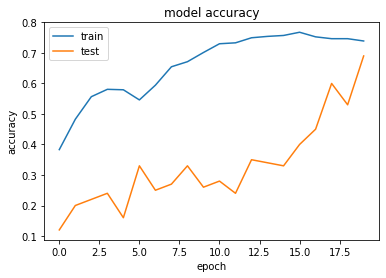

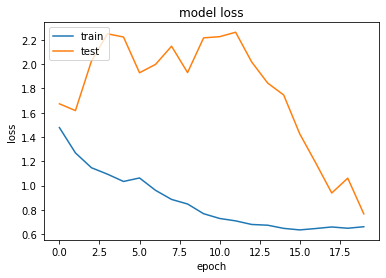

In [37]:
# Plotting the result of Model 7 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Got best test accuracy of 85 % and validation accuracy of 80% 

# Model 8 : CNN - LSTM Model , Increase layers , increase epoch to 25

In [39]:
input_shape=(30,120,120,3)

CNNlstm_3 = Sequential()
CNNlstm_3.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))


CNNlstm_3.add(Flatten())
CNNlstm_3.add(Dense(64,activation='relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(Dropout(0.25))

CNNlstm_3.add(Dense(64,activation='relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(Dropout(0.25))


CNNlstm_3.add(Dense(5,activation='softmax'))

optimiser = tf.keras.optimizers.Adam()
CNNlstm_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_3.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_42 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_17 (Conv3D)          (None, 30, 120, 120, 16)  6928      
                                                                 
 activation_17 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_43 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                     

In [40]:
print("Total Params in model:", CNNlstm_3.count_params())

Total Params in model: 1287989


In [41]:
batch_size = 20
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 25
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 25


In [42]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [43]:
history = CNNlstm_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_207/2700097509.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = CNNlstm_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7223 - categorical_accuracy: 0.3484Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-11-0712_35_10.536448/model-00001-1.72231-0.34842-2.14417-0.21000.h5
34/34 [==============================] - 60s 2s/step - loss: 1.7223 - categorical_accuracy: 0.3484 - val_loss: 2.1442 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3185 - categorical_accuracy: 0.4887
Epoch 00002: saving model to model_init_2024-11-0712_35_10.536448/model-00002-1.31849-0.48869-1.70478-0.22000.h5
34/34 [==============================] - 50s 2s/step - loss: 1.3185 - categorical_accuracy: 0.4887 - val_loss: 1.7048 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1857 - categorical_accuracy:

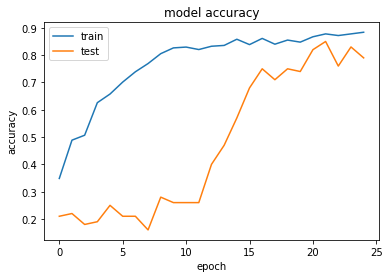

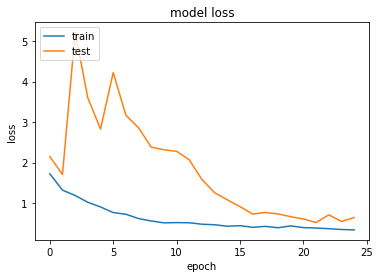

In [44]:
# Plotting the result of Model 8 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# The best test accuracy is 90 % and best validation accuracy is 79 %

# Model 9 : CNN - LSTM Model, Increase network paramaters

In [45]:
input_shape=(30,120,120,3)

CNNlstm_4 = Sequential()
CNNlstm_4.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_4.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_4.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_4.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())

CNNlstm_4.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_4.add(Activation('relu'))
CNNlstm_4.add(BatchNormalization())
CNNlstm_4.add(MaxPooling3D(pool_size=(2, 2, 2)))


CNNlstm_4.add(Flatten())
CNNlstm_4.add(Dense(128,activation='relu'))
CNNlstm_4.add(BatchNormalization())
CNNlstm_4.add(Dropout(0.25))

CNNlstm_4.add(Dense(128,activation='relu'))
CNNlstm_4.add(BatchNormalization())
CNNlstm_4.add(Dropout(0.25))


CNNlstm_4.add(Dense(5,activation='softmax'))

optimiser = tf.keras.optimizers.Adam()
CNNlstm_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (CNNlstm_4.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_52 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_25 (Conv3D)          (None, 30, 120, 120, 16)  6928      
                                                                 
 activation_25 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_53 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                     

In [ ]:
print("Total Params in model:", CNNlstm_4.count_params())

In [47]:
batch_size = 20
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 25
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 25


In [48]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [49]:
history = CNNlstm_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_207/2772065864.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = CNNlstm_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6587 - categorical_accuracy: 0.3801Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-11-0712_59_01.581844/model-00001-1.65873-0.38009-1.65538-0.28000.h5
34/34 [==============================] - 54s 2s/step - loss: 1.6587 - categorical_accuracy: 0.3801 - val_loss: 1.6554 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3577 - categorical_accuracy: 0.4902
Epoch 00002: saving model to model_init_2024-11-0712_59_01.581844/model-00002-1.35770-0.49020-2.54279-0.26000.h5
34/34 [==============================] - 51s 2s/step - loss: 1.3577 - categorical_accuracy: 0.4902 - val_loss: 2.5428 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9960 - categorical_accuracy:

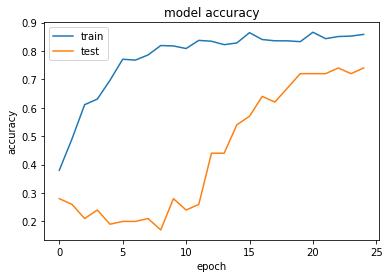

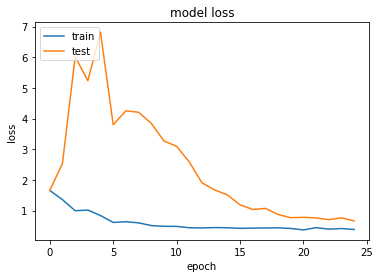

In [50]:
# Plotting the result of Model 9 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Got best test accuracy of 85% and validation accuracy of 74% 

# Model 10 : CNN LSTM with GRU

In [51]:
input_shape=(30,120,120,3)

GRU_lstm = Sequential()

GRU_lstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(input_shape)))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))


GRU_lstm.add(TimeDistributed(Flatten()))


GRU_lstm.add(GRU(128))
GRU_lstm.add(Dropout(0.25))

GRU_lstm.add(Dense(128,activation='relu'))
GRU_lstm.add(Dropout(0.25))

GRU_lstm.add(Dense(5, activation='softmax'))
optimiser = tf.keras.optimizers.Adam()
GRU_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (GRU_lstm.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 30, 60, 60, 32)  

In [52]:
print("Total Params in model:", GRU_lstm.count_params())

Total Params in model: 2573541


In [53]:
batch_size = 20
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [54]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [55]:
history = GRU_lstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_207/3182088282.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = GRU_lstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4844 - categorical_accuracy: 0.3469Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-11-0713_22_56.141230/model-00001-1.48444-0.34691-4.11489-0.16000.h5
34/34 [==============================] - 53s 2s/step - loss: 1.4844 - categorical_accuracy: 0.3469 - val_loss: 4.1149 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2297 - categorical_accuracy: 0.4721
Epoch 00002: saving model to model_init_2024-11-0713_22_56.141230/model-00002-1.22974-0.47210-3.66508-0.12000.h5
34/34 [==============================] - 50s 2s/step - loss: 1.2297 - categorical_accuracy: 0.4721 - val_loss: 3.6651 - val_categorical_accuracy: 0.1200 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0415 - categorical_accuracy:

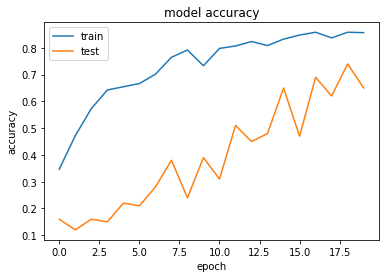

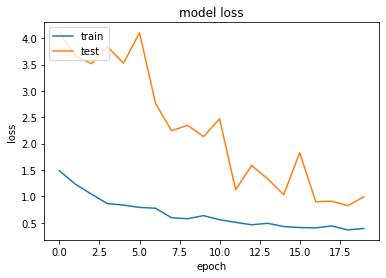

In [56]:
# Plotting the result of Model 10 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# We have got best test accuracy of 94 % and val accuracy of 79 %

### Lets use the pre-trained model for the transfer learning.

# Model 11: Model with Transfer Learning

In [57]:
# Importing the transfer learning model:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

17235968/17225924 [==============================] - 2s 0us/step


In [ ]:
# MobileNet V2 model accepts one of the following formats: (96, 96), (128, 128), (160, 160),(192, 192), or (224, 224).
# Hence, we have got this warning for the input as we have not specified the input size while import.

In [59]:
# Building the model :

input_shape = (18,120,120,3)
        
mobileNetModel= Sequential()
mobileNetModel.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


for layer in mobileNetModel.layers:
    layer.trainable = False


mobileNetModel.add(TimeDistributed(BatchNormalization()))
mobileNetModel.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModel.add(TimeDistributed(Flatten()))

mobileNetModel.add(LSTM(128))
mobileNetModel.add(Dropout(0.25))

mobileNetModel.add(Dense(128,activation='relu'))
mobileNetModel.add(Dropout(0.25))

mobileNetModel.add(Dense(5, activation='softmax'))


optimiser = tf.keras.optimizers.Adam()
mobileNetModel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mobileNetModel.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_81 (TimeDi  (None, 18, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_82 (TimeDi  (None, 18, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 18, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_84 (TimeDi  (None, 18, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_5 (LSTM)               (None, 128)             

In [60]:
print("Total Params in model:", mobileNetModel.count_params())

Total Params in model: 3840453


In [61]:
def generatorMobileNet(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,120,120,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [62]:
batch_size = 5
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [63]:
train_generator = generatorMobileNet(train_path, train_doc, batch_size)
val_generator = generatorMobileNet(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [64]:
history = mobileNetModel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_207/3268031849.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = mobileNetModel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.4529 - categorical_accuracy: 0.3741Source path =  /home/datasets/Project_data/val ; batch size = 5

Epoch 00001: saving model to model_init_2024-11-0714_01_53.825200/model-00001-1.45295-0.37406-1.01029-0.63000.h5
133/133 [==============================] - 37s 249ms/step - loss: 1.4529 - categorical_accuracy: 0.3741 - val_loss: 1.0103 - val_categorical_accuracy: 0.6300 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9788 - categorical_accuracy: 0.6244
Epoch 00002: saving model to model_init_2024-11-0714_01_53.825200/model-00002-0.97877-0.62443-0.85457-0.63000.h5
133/133 [==============================] - 32s 238ms/step - loss: 0.9788 - categorical_accuracy: 0.6244 - val_loss: 0.8546 - val_categorical_accuracy: 0.6300 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.6648 - categor

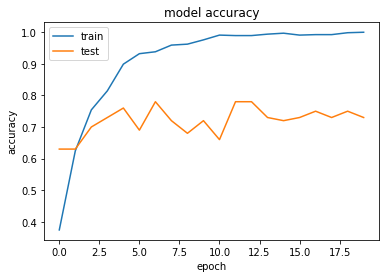

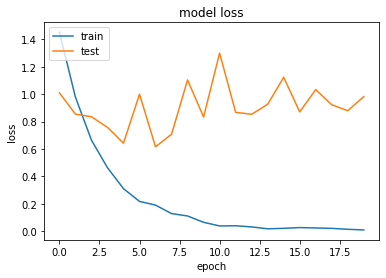

In [65]:

# Plotting the result of Model 11:

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Best test accuracy of 91 % and val accuracy of 55 %.

#### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement.

# Model 12: Transfer Learning with GRU and training all weights

In [66]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

input_shape = (18,120,120,3)
        
mobileNetModelWeight = Sequential()
mobileNetModelWeight.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


mobileNetModelWeight.add(TimeDistributed(BatchNormalization()))
mobileNetModelWeight.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModelWeight.add(TimeDistributed(Flatten()))

mobileNetModelWeight.add(GRU(128))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(128,activation='relu'))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(5, activation='softmax'))


optimiser = tf.keras.optimizers.Adam()
mobileNetModelWeight.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mobileNetModel.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_81 (TimeDi  (None, 18, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_82 (TimeDi  (None, 18, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 18, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_84 (TimeDi  (None, 18, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_5 (LSTM)               (None, 128)             

In [67]:
print("Total Params in model:", mobileNetModel.count_params())

Total Params in model: 3840453


In [68]:
batch_size = 5
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [69]:
train_generator = generatorMobileNet(train_path, train_doc, batch_size)
val_generator = generatorMobileNet(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [70]:

history = mobileNetModelWeight.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_207/950158795.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = mobileNetModelWeight.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.2627 - categorical_accuracy: 0.4691Source path =  /home/datasets/Project_data/val ; batch size = 5

Epoch 00001: saving model to model_init_2024-11-0714_13_06.803042/model-00001-1.26267-0.46908-0.84123-0.68000.h5
133/133 [==============================] - 40s 266ms/step - loss: 1.2627 - categorical_accuracy: 0.4691 - val_loss: 0.8412 - val_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.8836 - categorical_accuracy: 0.6516
Epoch 00002: saving model to model_init_2024-11-0714_13_06.803042/model-00002-0.88360-0.65158-1.21132-0.49000.h5
133/133 [==============================] - 34s 258ms/step - loss: 0.8836 - categorical_accuracy: 0.6516 - val_loss: 1.2113 - val_categorical_accuracy: 0.4900 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.7402 - categor

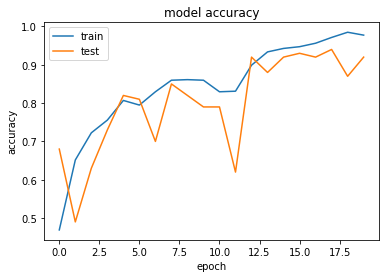

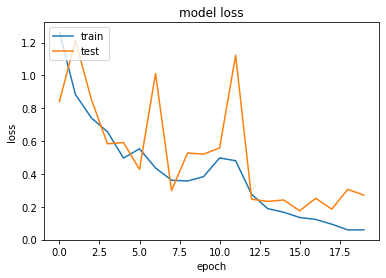

In [71]:
# Plotting the result of Model 12:

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Got the best test accuracy of 97 % and val accuracy of 94 %.

# Final Model Choosen :

## Transfer Learning with GRU and training all weights
#### model name :model_init_2024-11-0714_13_06.803042/model-00018-0.09344-0.97134-0.18511-0.94000.h5
#### This has completed training in 1000 seconds (16.7 minutes) which is decent with good accuracy of 94 % over validation data.

### *************************************************** END OF CASE STUDY *********************************************************